In [41]:
import pandas as pd 
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, String, Float, DateTime
from sqlalchemy.dialects.sqlite import DATETIME

In [42]:
df = pd.read_csv('../Resources/collision_2022.csv')

In [43]:
df = df.drop_duplicates(subset=['collision_id'], keep='first').set_index('collision_id')

In [44]:
df['zip_code'] = df['zip_code'].astype(str)

In [45]:
df['crash_datetime'] = pd.to_datetime(df['crash_datetime'])

In [46]:
df.drop(columns='location', inplace=True)

In [47]:
df.rename(columns={'vehicle_type_code1': 'vehicle_type_code_1', 'vehicle_type_code2':'vehicle_type_code_2'}, inplace=True)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103789 entries, 4513547 to 4648224
Data columns (total 25 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   crash_datetime                 103789 non-null  datetime64[ns]
 1   crash_day_of_week              103789 non-null  int64         
 2   street_address                 103787 non-null  object        
 3   number_of_persons_injured      103789 non-null  int64         
 4   number_of_persons_killed       103789 non-null  int64         
 5   number_of_pedestrians_injured  103789 non-null  int64         
 6   number_of_pedestrians_killed   103789 non-null  int64         
 7   number_of_cyclist_injured      103789 non-null  int64         
 8   number_of_cyclist_killed       103789 non-null  int64         
 9   number_of_motorist_injured     103789 non-null  int64         
 10  number_of_motorist_killed      103789 non-null  int64         
 11

In [49]:
import requests
import pandas as pd

# Fetch data from the API
additional_columns = requests.get("https://data.cityofnewyork.us/resource/h9gi-nx95.json")
additional_columns_data = additional_columns.json()
additional_df = pd.DataFrame(additional_columns_data)
additional_df.set_index('collision_id', inplace=True)
additional_df.head(5)

,crash_date,crash_time,on_street_name,off_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,...,latitude,longitude,location,cross_street_name,contributing_factor_vehicle_3,vehicle_type_code_3,contributing_factor_vehicle_4,vehicle_type_code_4,contributing_factor_vehicle_5,vehicle_type_code_5
collision_id,,,,,,,,,,,,,,,,,,,,,
4455765,2021-09-11T00:00:00.000,2:39,WHITESTONE EXPRESSWAY,20 AVENUE,2,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4513547,2022-03-26T00:00:00.000,11:45,QUEENSBORO BRIDGE UPPER,NaN,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4541903,2022-06-29T00:00:00.000,6:55,THROGS NECK BRIDGE,NaN,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4456314,2021-09-11T00:00:00.000,9:35,NaN,NaN,0,0,0,0,0,0,...,40.667202,-73.8665,"{'latitude': '40.667202', 'longitude': '-73.86...",1211 LORING AVENUE,NaN,NaN,NaN,NaN,NaN,NaN
4486609,2021-12-14T00:00:00.000,8:13,SARATOGA AVENUE,DECATUR STREET,0,0,0,0,0,0,...,40.683304,-73.917274,"{'latitude': '40.683304', 'longitude': '-73.91...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
additional_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 6 to 1830
Data columns (total 67 columns):
 #   Column                                                                       Non-Null Count  Dtype 
---  ------                                                                       --------------  ----- 
 0   zip_code                                                                     1825 non-null   object
 1   GEOID                                                                        1825 non-null   object
 2   State                                                                        1825 non-null   object
 3   County                                                                       4 non-null      object
 4   City                                                                         4 non-null      object
 5   Best Population Year                                                         1825 non-null   object
 6   Population                                      

In [51]:
df.index = df.index.astype(str)
additional_df.index = additional_df.index.astype(str)

In [52]:
# rename columns contributing_factor_vehicle to contributing_factor_vehicle_1 
df.rename(columns={'contributing_factor_vehicle':'contributing_factor_vehicle_1'}, inplace=True)

In [53]:
df['contributing_factor_vehicle_2'] = additional_df['contributing_factor_vehicle_2']
df['contributing_factor_vehicle_3'] = additional_df['contributing_factor_vehicle_3']
df['contributing_factor_vehicle_4'] = additional_df['contributing_factor_vehicle_4']
df['contributing_factor_vehicle_5'] = additional_df['contributing_factor_vehicle_5']

In [54]:
df['vehicle_type_code_1'] = additional_df['vehicle_type_code1']
df['vehicle_type_code_2'] = additional_df['vehicle_type_code2']
df['vehicle_type_code_3'] = additional_df['vehicle_type_code_3']
df['vehicle_type_code_4'] = additional_df['vehicle_type_code_4']
df['vehicle_type_code_5'] = additional_df['vehicle_type_code_5']

In [55]:
crash_datetime = df['crash_datetime']
df.drop(labels=['crash_datetime'], axis=1, inplace=True)
df.insert(0, 'crash_datetime', crash_datetime)

In [56]:
demo_df = demo_df[['zip_code','Population Density','Population']].reset_index(drop=True)
demo_df.head()

,zip_code,Population Density,Population
0,10001,43227.1,26966
1,10002,93406.1,76807
2,10003,95235,54447
3,10004,10525.1,4795
4,10005,NaN,8637


In [57]:
df = df.reset_index().merge(demo_df, on='zip_code', how='left').set_index('collision_id')

In [58]:
demo_df = pd.read_excel('../Resources/NewYork_DemographicsByZipCode.xlsx')
demo_df = demo_df.iloc[3:]
demo_df = demo_df.rename(columns={'Geography': 'zip_code'}, inplace=False)
demo_df = demo_df.rename(columns={'Best Population Estimate': 'Population'}, inplace=False)
demo_df = demo_df.rename(columns={demo_df.columns[7]: 'Population Density'}, inplace=False)
demo_df = demo_df[(demo_df['zip_code'] != "New York") & (demo_df['zip_code'] != "name")]
demo_df.info()



<class 'pandas.core.frame.DataFrame'>
Index: 1826 entries, 5 to 1830
Data columns (total 67 columns):
 #   Column                                                                       Non-Null Count  Dtype 
---  ------                                                                       --------------  ----- 
 0   zip_code                                                                     1826 non-null   object
 1   GEOID                                                                        1826 non-null   object
 2   State                                                                        1826 non-null   object
 3   County                                                                       5 non-null      object
 4   City                                                                         5 non-null      object
 5   Best Population Year                                                         1826 non-null   object
 6   Population                                           

In [64]:
collision_by_zip_df = df.groupby('zip_code').size()
collision_by_zip_df = collision_by_zip_df.reset_index().rename(columns={"zip_code":"zipcodes",0:"# of Collisions"})
collision_by_zip_df['# of Collisions'] = collision_by_zip_df['# of Collisions'].astype('int')
collision_by_zip_df['zipcodes'] = collision_by_zip_df['zipcodes'].astype('str')
collision_by_zip_df.set_index('zipcodes', inplace=True)
collision_by_zip_df.head()

zip_code Population Density Population
0    06390               14.3         58
1    10001            43227.1      26966
2    10002            93406.1      76807
3    10003              95235      54447
4    10004            10525.1       4795

In [75]:
df = df.merge(demo_df, on = "zip_code",how='left')
df["Population"] = df["Population"].astype("float")

In [73]:
## add an attribute that classifies the hour of the day
df["crash_hour"] = df['crash_datetime'].dt.hour

def classify_hour(hour):
    if 4 <= hour < 7:
        return 'Early Morning'
    elif 7 <= hour < 10 or 16 <= hour < 20:
        return 'Rush Hours'
    elif 22 <= hour or hour < 4:
        return 'Late Night'
    else:
        return 'Normal Hours'

df['crash_hour_category'] = df['crash_hour'].apply(classify_hour)    
df = df.drop('crash_hour', axis=1)
column_to_move = df.pop('crash_hour_category')
df.insert(2, 'crash_hour_category', column_to_move)
df.head()

,crash_datetime,crash_day_of_week,crash_hour_category,street_name,borough,county,zip_code,latitude,longitude,number_of_persons_injured,...,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,Population Density,Population
0,2021-09-11 02:39:00,5,Late Night,Whitestone Expressway & 20 Avenue,Queens,Queens County,11356,40.712728,-74.006015,2,...,NaN,NaN,NaN,Sedan,Sedan,NaN,NaN,NaN,NaN,27295
1,2022-03-26 11:45:00,5,Normal Hours,Queensboro Bridge Upper,Manhattan,Queens County,10044,40.746402,-73.940191,1,...,NaN,NaN,NaN,Sedan,NaN,NaN,NaN,NaN,NaN,12155
2,2022-06-29 06:55:00,2,Early Morning,Throgs Neck Bridge,Bronx,Bronx County,10465,40.816416,-73.798616,0,...,NaN,NaN,NaN,Sedan,Pick-up Truck,NaN,NaN,NaN,NaN,46205
3,2021-09-11 09:35:00,5,Rush Hours,1211 Loring Avenue,Brooklyn,Kings County,11208,40.667202,-73.866500,0,...,NaN,NaN,NaN,Sedan,NaN,NaN,NaN,NaN,NaN,107724
4,2021-12-14 08:13:00,1,Rush Hours,Saratoga Avenue & Decatur Street,Brooklyn,Kings County,11233,40.683304,-73.917274,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85633


In [84]:
df["number_of_deaths"] = df["number_of_cyclist_killed"] + df["number_of_motorist_killed"] + df["number_of_pedestrians_killed"] + df["number_of_persons_killed"]
df["number_of_injuries"] = df["number_of_cyclist_injured"] + df["number_of_motorist_injured"] + df["number_of_pedestrians_injured"] + df["number_of_persons_injured"]

def classify_severity(deaths,injuries):
    if deaths > 0:
        return 'Fatal'
    elif injuries >= 2:
        return 'Serious'
    else:
        return 'Light'

df["severity_of_accident"] = df.apply(lambda row: classify_severity(row["number_of_deaths"], row["number_of_injuries"]), axis=1)

In [85]:
df.head()

,crash_datetime,crash_day_of_week,crash_hour_category,street_name,borough,county,zip_code,latitude,longitude,number_of_persons_injured,...,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,Population Density,Population,number_of_deaths,number_of_injuries,severity_of_accident
0,2021-09-11 02:39:00,5,Late Night,Whitestone Expressway & 20 Avenue,Queens,Queens County,11356,40.712728,-74.006015,2,...,Sedan,Sedan,NaN,NaN,NaN,NaN,27295.0,0,4,Serious
1,2022-03-26 11:45:00,5,Normal Hours,Queensboro Bridge Upper,Manhattan,Queens County,10044,40.746402,-73.940191,1,...,Sedan,NaN,NaN,NaN,NaN,NaN,12155.0,0,2,Serious
2,2022-06-29 06:55:00,2,Early Morning,Throgs Neck Bridge,Bronx,Bronx County,10465,40.816416,-73.798616,0,...,Sedan,Pick-up Truck,NaN,NaN,NaN,NaN,46205.0,0,0,Light
3,2021-09-11 09:35:00,5,Rush Hours,1211 Loring Avenue,Brooklyn,Kings County,11208,40.667202,-73.866500,0,...,Sedan,NaN,NaN,NaN,NaN,NaN,107724.0,0,0,Light
4,2021-12-14 08:13:00,1,Rush Hours,Saratoga Avenue & Decatur Street,Brooklyn,Kings County,11233,40.683304,-73.917274,0,...,NaN,NaN,NaN,NaN,NaN,NaN,85633.0,0,0,Light


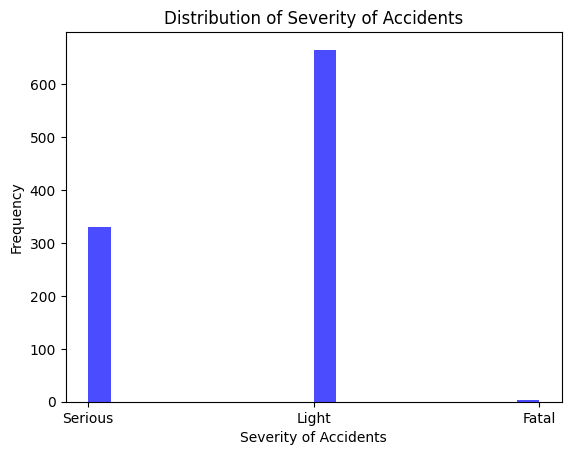

In [87]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a histogram to visualize the distribution of the severity of accidents
plt.hist(df['severity_of_accident'], bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Severity of Accidents')
plt.xlabel('Severity of Accidents')
plt.ylabel('Frequency')
plt.show()


In [18]:
import json

# Define the file path
file_path = '../Resources/nyc_geojson_by_zip.json'

# Open the file and load the GeoJSON data
with open(file_path, 'r') as file:
    geojson_data = json.load(file)

In [19]:
# add the collision count to the geojson data
for feature in geojson_data['features']:
    zipcode = feature['properties']['postalCode']
    if zipcode in collision_by_zip_df.index:
        feature['properties']['collision_count'] = collision_by_zip_df.loc[zipcode]['# of Collisions']
    else:
        feature['properties']['collision_count'] = 0

In [20]:
import numpy as np
# Custom function to handle non-serializable data types
def convert(o):
    if isinstance(o, np.integer):
        return int(o)
    raise TypeError

# Use json.dump with the custom function to handle non-serializable data
with open('../static/data/nyc_geojson_by_zip_with_counts.json', 'w') as file:
    json.dump(geojson_data, file, default=convert)

In [21]:
motor_collisions = Table('motor_collisions', metadata,
                         Column('collision_id', Integer, primary_key=True),
                         Column('crash_datetime', DateTime),
                         Column('crash_day_of_week', Integer),
                         Column('street_address', String), 
                         Column('borough', String),
                         Column('county', String),
                         Column('zip_code', String),
                         Column('latitude', Float),
                         Column('longitude', Float),
                         Column('number_of_persons_injured', Integer),
                         Column('number_of_persons_killed', Integer),
                         Column('number_of_pedestrians_injured', Integer),
                         Column('number_of_pedestrians_killed', Integer),
                         Column('number_of_cyclist_injured', Integer),
                         Column('number_of_cyclist_killed', Integer),
                         Column('number_of_motorist_injured', Integer),
                         Column('number_of_motorist_killed', Integer),
                         Column('contributing_factor_vehicle_1', String),
                         Column('contributing_factor_vehicle_2', String),
                         Column('contributing_factor_vehicle_3', String),
                         Column('contributing_factor_vehicle_4', String),
                         Column('contributing_factor_vehicle_5', String),
                         Column('vehicle_type_code_1', String),
                         Column('vehicle_type_code_2', String),
                         Column('vehicle_type_code_3', String),
                         Column('vehicle_type_code_4', String),
                         Column('vehicle_type_code_5', String),
                         Column('Population', Float),
                         Column('Population Density', String)
                         )
metadata.create_all(engine)

In [22]:
df.to_sql('motor_collisions', con=engine, if_exists='append', index=True)

103789

In [23]:
from sqlalchemy import inspect

inspector = inspect(engine)
print(inspector.get_table_names())  # Check if the table is listed
print(inspector.get_columns('motor_collisions'))  # Check the structure of the table


['collision_by_zip', 'motor_collisions']
[{'name': 'collision_id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}, {'name': 'crash_datetime', 'type': DATETIME(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'crash_day_of_week', 'type': INTEGER(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'street_address', 'type': VARCHAR(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'borough', 'type': VARCHAR(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'county', 'type': VARCHAR(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'zip_code', 'type': VARCHAR(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'latitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'pr

In [24]:
from sqlalchemy.ext.automap import automap_base
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['collision_by_zip', 'motor_collisions']